In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-10-22 23:45:21.540798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-22 23:45:22.862267: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-22 23:45:22.863139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-22 23:45:22.898556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce GT 710 computeCapability: 3.5
coreClock: 0.954GHz coreCount: 1 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 11.92GiB/s
2021-10-22 23:45:22.898591: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-22 23:45:22.900640: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
20

In [3]:
stream = "gd1_tail"
save_label = None

In [4]:
df = load_file(stream = stream, percent_bkg = 1)

Before reduction, stream stars make up 0.039% of the dataset.
After reduction, stream stars make up 3.713% of the dataset.


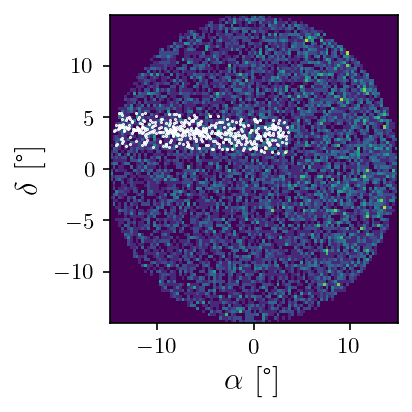

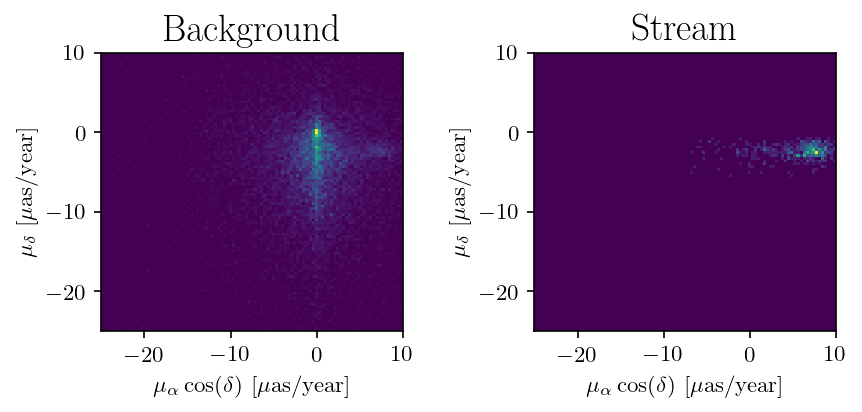

In [5]:
visualize_stream(df)

/home/mpettee/GaiaCWoLa/functions.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)


Signal region has 355 stream and 2,792 bkg events.
Sideband region has 106 stream and 2,779 bkg events.
Total counts: SR = 3,147, SB = 2,885


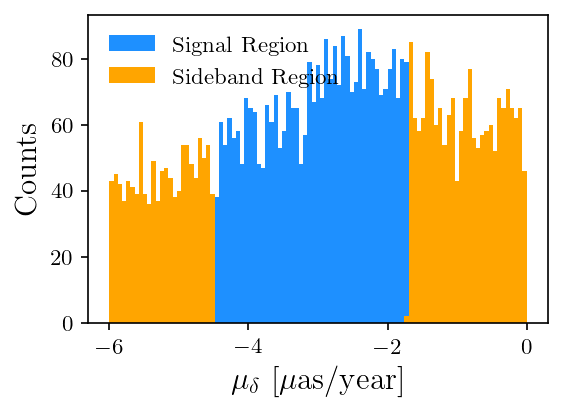

In [6]:
df_slice = signal_sideband(df, stream = stream, save_label = save_label)

In [7]:
### Prepare datasets for training
training_vars = ['μ_α','δ','α','color','mag']
train, validate, test = np.split(df_slice.sample(frac=1), [int(.7*len(df_slice)), int(.85*len(df_slice))]) # 70/15/15 train/validate/test split

x_train, x_val, x_test = [train[training_vars], validate[training_vars], test[training_vars]]
y_train, y_val, y_test = [train.label, validate.label, test.label]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [8]:
### Define model architecture 
save_name = "test"
layer_size = 128
dropout = 0.2
reg = regularizers.l2(1e-2)

model = Sequential()

model.add(Dense(layer_size, input_dim=len(training_vars), activation='relu',
               activity_regularizer=reg
               )) 
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=reg
               ))
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(layer_size, activation='relu',
               activity_regularizer=reg
               ))
if dropout != 0: 
    model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

# stops if val_loss doesn't improve for [patience] straight epochs
early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=20, 
                                         verbose=1) 

# saves weights from the epoch with lowest val_loss 
os.makedirs("./weights", exist_ok=True)
checkpoint = callbacks.ModelCheckpoint("./weights/"+save_name+".h5", 
                                       monitor='val_loss', 
                                       mode='auto', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       save_weights_only=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

2021-10-22 23:45:26.247480: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-22 23:45:26.249284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce GT 710 computeCapability: 3.5
coreClock: 0.954GHz coreCount: 1 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 11.92GiB/s
2021-10-22 23:45:26.249345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-22 23:45:26.249379: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-22 23:45:26.249406: I tensorflow/stream_executor/platform

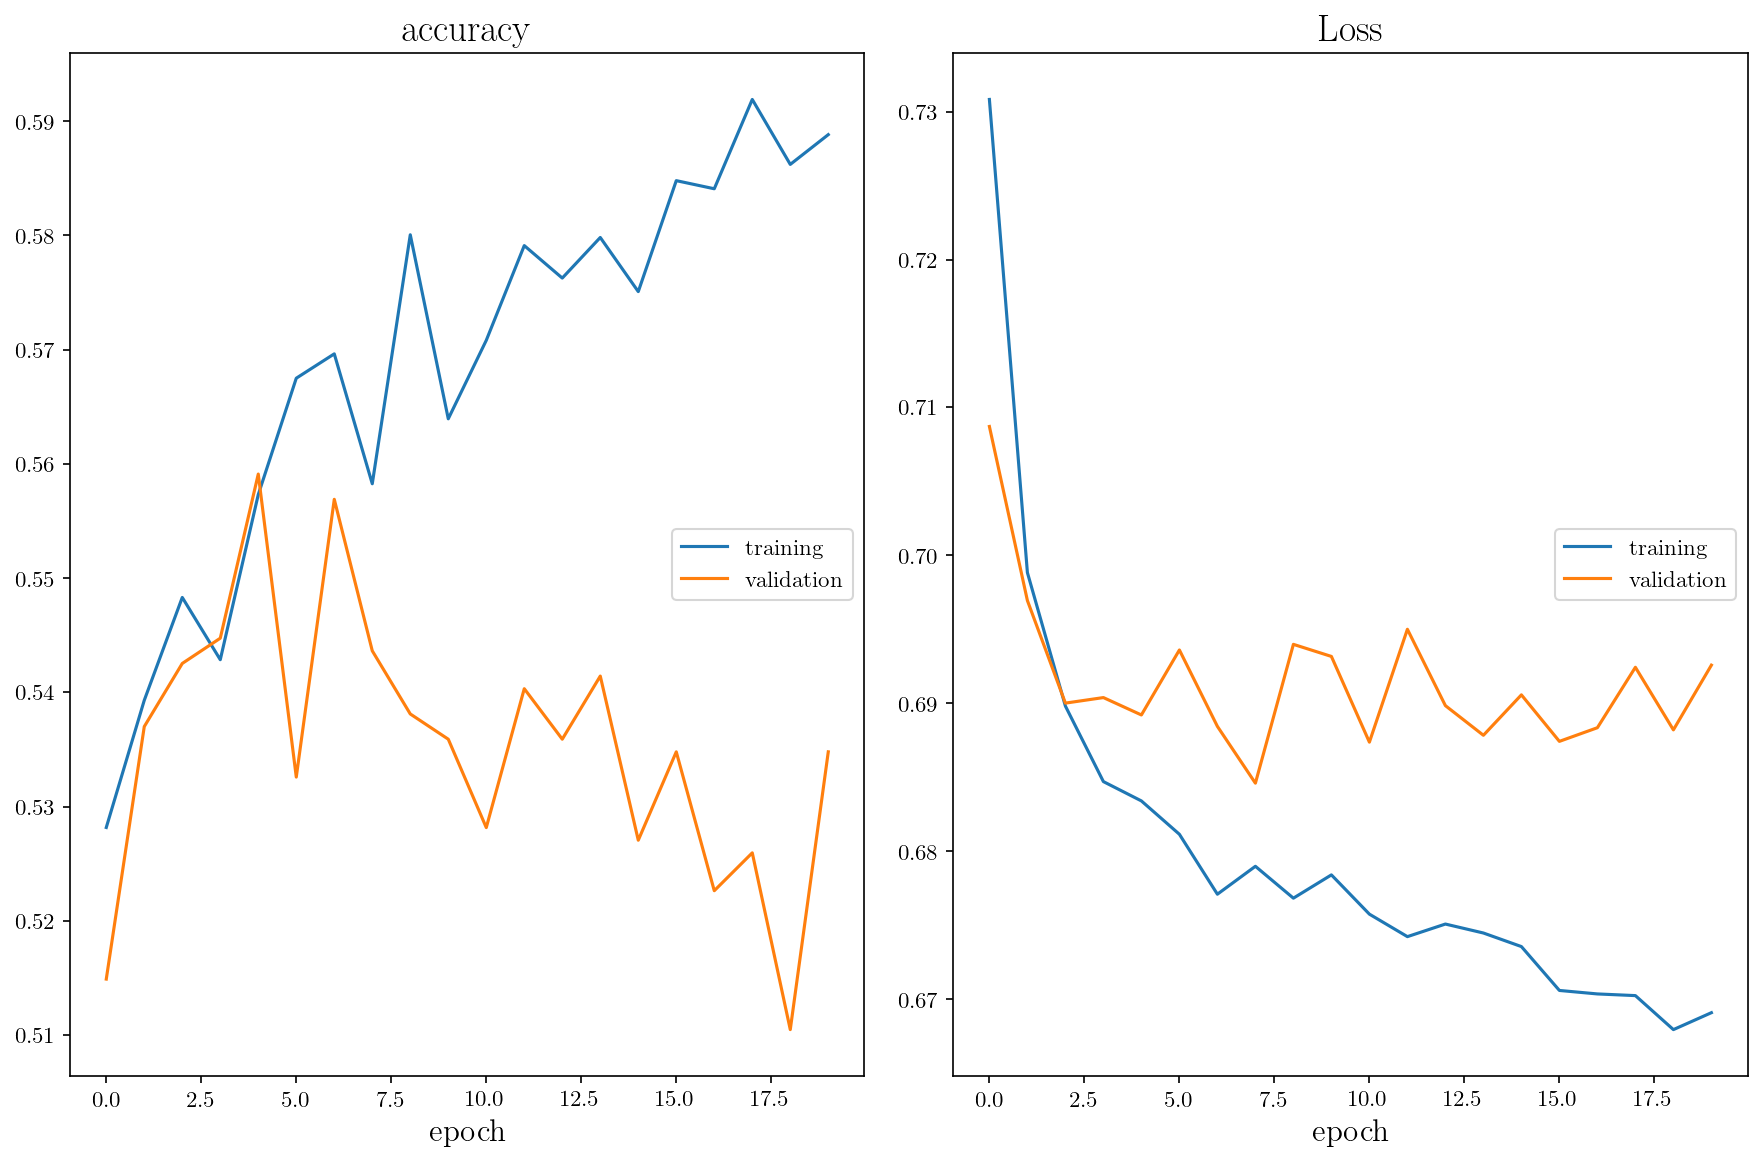

accuracy
	training         	 (min:    0.528, max:    0.592, cur:    0.589)
	validation       	 (min:    0.510, max:    0.559, cur:    0.535)
Loss
	training         	 (min:    0.668, max:    0.731, cur:    0.669)
	validation       	 (min:    0.685, max:    0.709, cur:    0.693)

Epoch 00020: val_loss did not improve from 0.68460


In [9]:
### Train!
history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(x_val,y_val),
                    callbacks = [PlotLossesKeras(),checkpoint,early_stopping],
                    verbose = 2,
                   )

AUC: 0.6028333333333333
Maximum purity of 100.0% at 0.1%
Cut at 0.1%...
Efficiency: 1.2%
Purity: 100.0%
Cut at 1%...
Efficiency: 12.0%
Purity: 100.0%
Cut at 5%...
Efficiency: 47.0%
Purity: 84.8%
Cut at 10%...
Efficiency: 69.9%
Purity: 63.7%
Cut at 20%...
Efficiency: 95.2%
Purity: 43.6%


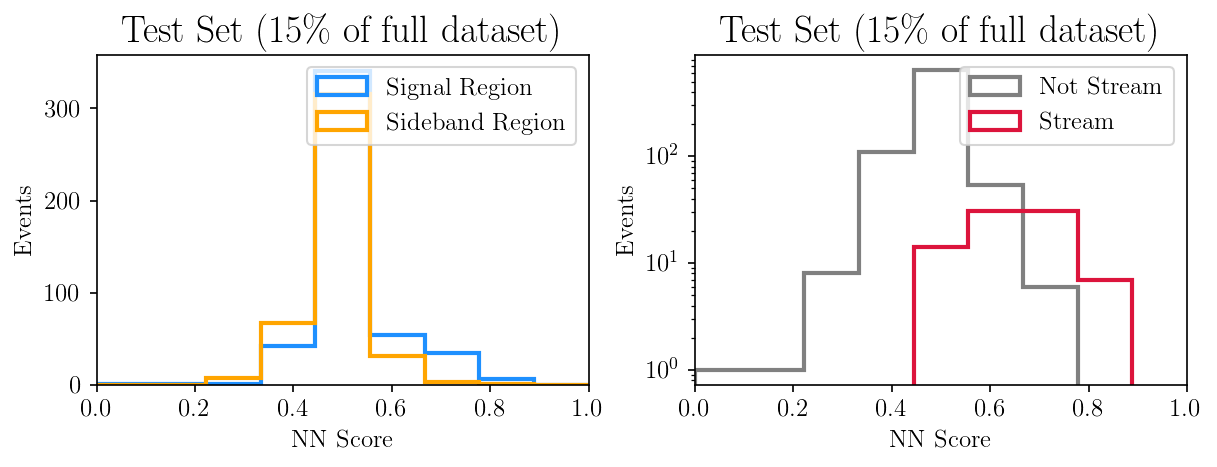

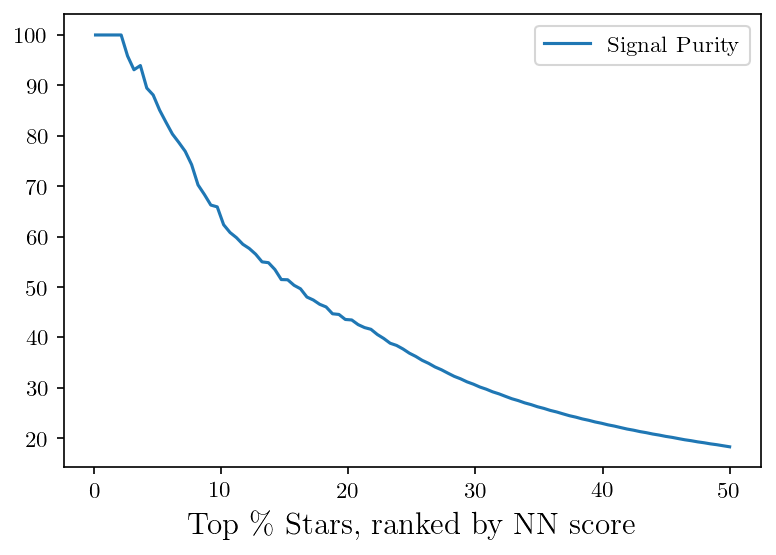

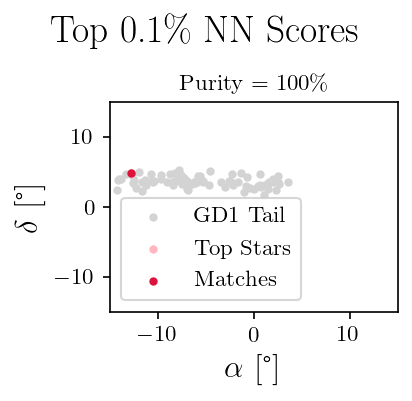

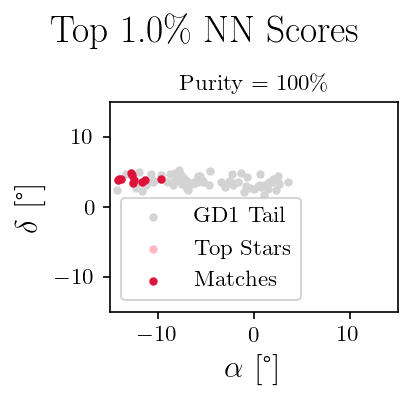

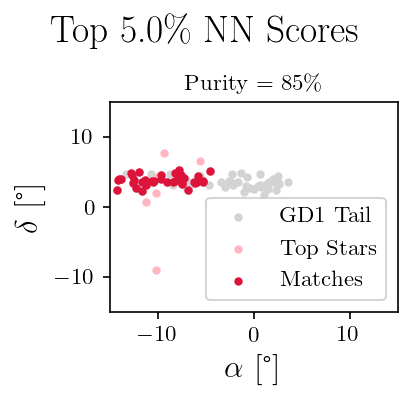

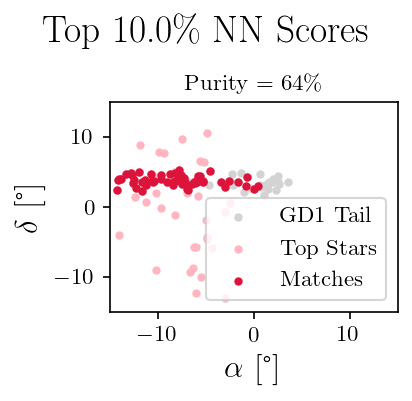

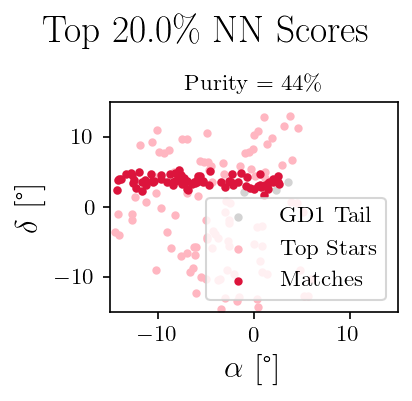

In [10]:
### Load best weights
model.load_weights("./weights/"+save_name+".h5")

### Add the NN prediction score to the test set: 
test["nn_score"] = model.predict(x_test)
fake_eff_baseline, real_eff_baseline, thresholds = roc_curve(np.asarray(y_test), test.nn_score)
auc_baseline = auc(fake_eff_baseline, real_eff_baseline)
print("AUC: {}".format(auc_baseline))

### Plot scores:
plot_results(test, save_label)